# 인공 신경망

## 데이터 준비하기

딥러닝 배울 때 많이 사용하는 데이터 셋으로 **MNIST**가 있다. 이 데이터에는 손으로 쓴 0부터 9까지의 숫자가 있다. 

**패션 MNIST**는 데이터 크기와 개수는 동일하지만 숫자 대신 패션 아이템으로 이루어진 데이터이다. 이를 다운받자.

In [2]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_input.shape, train_target.shape) # 훈련 세트의 크기

(60000, 28, 28) (60000,)


60,000개의 이미지, 각 이미지는 28 x 28 크기. 타깃도 60,000개의 벡터인 것을 확인할 수 있다.

In [4]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


In [13]:
train_input

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

몇 개의 샘플을 그림으로 출력해보자.

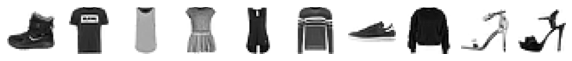

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(10,10)) # 6장 참고
for i in range(10):
  axs[i].imshow(train_input[i], cmap='gray_r')
  axs[i].axis('off')
plt.show()

이 샘플들의 타깃값을 보자.

In [7]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패션 MNIST의 타깃은 0~9까지의 숫자 레이블로 구성된다.
0. 티셔츠
1. 바지
2. 스웨터
3. 드레스
4. 코트
5. 샌달
6. 셔츠
7. 스니커즈
8. 가방
9. 앵클 부츠

레이블 당 샘플 개수를 확인해보자.

In [8]:
import numpy as np
print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


레이블당 6,000개의 샘플이 있다. 이제 로지스틱 회귀로 아이템을 분류해보자.

## 로지스틱 회귀로 패션 아이템 분류하기

샘플이 60,000개나 되기 때문에 전체 데이터를 한꺼번에 사용하여 모델을 훈련하는 것보다 샘플을 하나씩 꺼내서 모댈을 훈련하는 방법이 효율적이다.
-> **확률적 경사 하강법**

### 데이터 전처리

확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향을 따라 이동한다. 모든 특성을 동일선상에서 비교하기 위해선 스케일을 일치시켜야 한다.

사진은 픽셀로 이루어져 있다. 값의 범위를 0과 1사이의 값으로 정규화 하려면 어떻게 해야 할까?

각 픽셀은 0 ~ 255 사이의 정숫값을 가진다. 그러므로 각 픽셀을 255로 나눈다면 0 ~ 1 사이의 값으로 정규화할 수 있다. 

In [9]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28) #원본 데이터의 두 번재, 세 번째 차원이 1차원으로 합쳐짐
print(train_scaled.shape)

(60000, 784)


각 픽셀의 데이터(숫자)가 이미지 단위로 합쳐조 총 784개의 픽셀로 이루어진 60,000개의 샘플이 준비되었다.

### 학습하기

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log', max_iter=5, random_state=42) # 손실함수를 로지스틱 손실 함수로 지정.
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

0.8195666666666668


별로 만족스럽지 못한 점수이다.SGDClassifier의 반복 횟수(max_iter)를 늘려도 성능이 크게 향상되지는 않았다. 

로지스틱 회귀 공식이 이렇게 구성되었을 것이다.

**z_티셔츠 = w1 x (픽셀1) + w2(픽셀2) + ... + w784 x (픽셀784) + b**


**z_바지 = w1' x (픽셀1) + w2'(픽셀2) + ... + w784' x (픽셀784) + b'**

바지에 대한 로지스틱 회귀 공식도 티셔츠에 대한 선형 방정식과 매우 비슷하다. 하지만 바지에 대한 출력을 계산하기 위해선 가증치와 절편이 달라야 한다.

이렇게 나머지 클래스들에 대해서도 선형방벙식을 구했을 것이다. 그리고 **각각의 선형방정식의 각 픽셀별 가중치는 서로 모두 달라야 한다.**

이렇게 나온 z값을 소프트맥스 함수를 통과하여 각 클래스에 대한 확률을 얻는다.

## **인공 신경망(artificial neural network,ANN)**

가장 기본적인 인공 신경망은 **확률적 경사 하강법을 사용하는 로지스틱 회귀**와 같다. 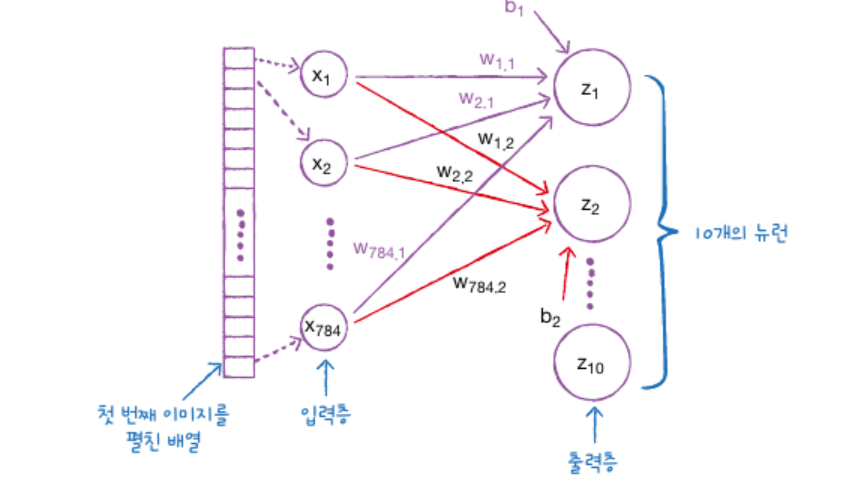

클래스가 총 10개 이므로 10개 z값을 계산한다. 이를 바탕으로 클래스를 예측하기 때문에 신경망의 **최종값**을 만든다는 의미에서 **출력층(output layer)**이라고 부른다.

인공 신경망에서 z값을 계산하는 단위를 뉴런(neuron)이라고 부른다. 최근에는 뉴런이라는 표현 대신 유닛(unit)이라고 부르는 사람이 많아지고 있다고 한다.

그리고 픽셀을 나타는 x1 ~ x784는 까지를 **입력층(input layer)**라고 부른다. 입력층은 값 자체이고 특별한 계산을 하지 않는다.

가중치는 w로 펴현되는데 x1의 입력에 z1에 관련된 가중치라면 W1.1로 표현된다.

절편은 뉴런마다 하나씩 있으므로 bi로 표현한다.


### **텐서플로(TensorFlow)**

최신 라이브러리들은 SGDClassifier에는 없는 기능을 제공한다. 이를 활용해 더 좋은 성능을 얻을 수 있다.

그럼 가장 인기가 높은 딥러닝 라이브러리 텐서플로를 사용해 모델을 만들어보자. 텐서플로는 구글이 2015년에 공개한 딥러닝 라이브러리다. 

텐서플로에는 저수준 API와 고수준 API가 있는데 케라스(Keras)가 텐서플로의 고수준 API이다.

또 딥러닝 라이브러리의 장점은 GPU를 사용하여 인공신경망을 훈련한다는 점이다. GPU는 벡터와 행렬 연산에 매우 최적화되어 있어 인공 신경망에 매우 적합하다.

### 텐서플로로 인공신경망 모델 만들기

In [11]:
import tensorflow as tf

In [12]:
from tensorflow import keras

로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.

이렇게 하는 이유는
1. 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고,
2. 교차 점증을 수행하기에는 훈련 시간이 너무 오래 걸리기 때문(어떤 딥러닝 모델은 훈련하는데 몇 시간, 며칠이 걸릴 수 있다.)

#### 데이터 준비하기

In [14]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [16]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [17]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


훈련 세트에서 20%를 검증 세트로 덜어냈다.

먼저 훈련 세트로 모델을 만들고, 검증 세트로 훈련한 모델을 평가해보자.

#### 밀집층(dense layer) 만들기

인공 신경망에서 가장 오른쪽에 있는 출력층을 만들 것이다.

케라스에는 다양한 층이 준비되어 있는데, 가장 기본이 되는 층은 **밀집층(dense layer)이다.**

밀집층이란 이름이 붙은 이유는 아래 그림과 같이 출력층의 뉴런 하나당 784개의 선이 빽빽하게 연결되어 있기 때문이다.
 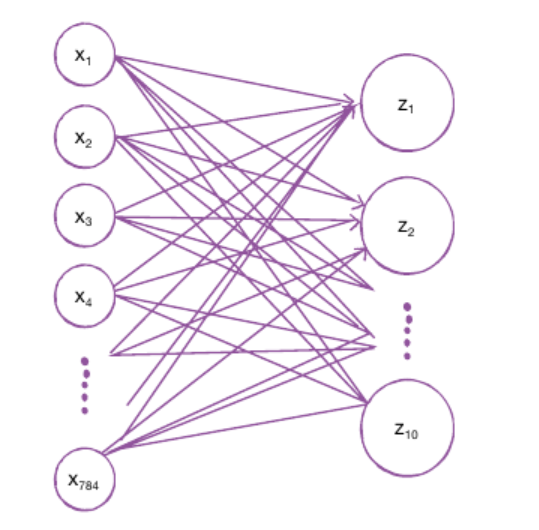

이런 층을 양쪽의 뉴련이 모두 연결하고 있어 **완전 연결층(fully connected layer)**라고도 부른다.

In [18]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,)) #(뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기[튜플로 지정])

다중 분류이기 때문에 소프트맥스를 취해준 것을 볼 수 있다. 

이처럼 소프트 맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 **활성화 함수(activation fucntion)**이라 부른다.

#### 밀집층을 가진 신경망 모델 만들기

In [19]:
model = keras.Sequential(dense)

여기서의 model이 바로 신경망 모델이다.

#### 훈련하기 전 설정하기, 원-핫 인코딩(one-hot encoding)

In [20]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

케라스 모델은 훈련하기 전에 설정 단계가 있다. compile() 메서드에서 손실 함수의 종류를 지정해줘야 한다.

*   이진 분류: loss = 'binary_crossentropy'
*   다중 분류: loss= 'categorical_crossentropy'



그런데 **sparse**(*드문,희소)는 무엇을 의미하는 것일까?

소프트맥스를 거친 후 각 클래스 별로 확률이 나올 것이다.

이때, 타깃에 해당하는 확률만 남겨 놓기 위해 나머지 확률에는 0을 곱한다.

예를 들어 샘플이 티셔츠인 경우 첫번째 출력 확률이 a1에만 손실 함수를 적용하고 나머지 확률에는 0을 곱해버린다.

이렇게 하여 손실함수는 a1이 1에 가까워지도록 가중치를 갱신할 것이다.

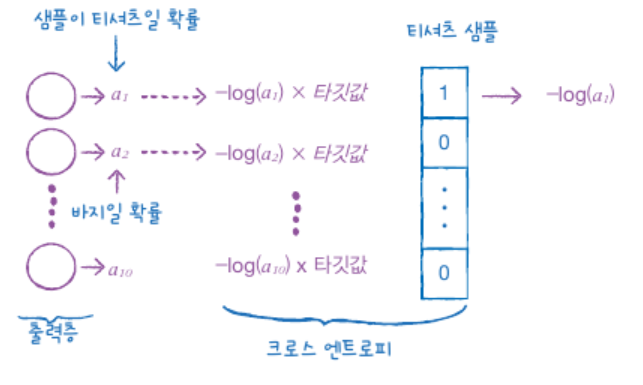

[a1, a2, a3, ... , a9, a10] x [1,0,0, ... , 0,0]

길이가 같은 넘파이 배열 곱셈은 원소별 곱셉으로 수행된다.

이처럼 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것을 원-핫 인코딩이라 부른다.

다중 분류에서는 0, 1, 2, 3과 같이 정수로 된 타깃값이 있는데 이를 원-핫 인코딩으로 변환해야 한다.

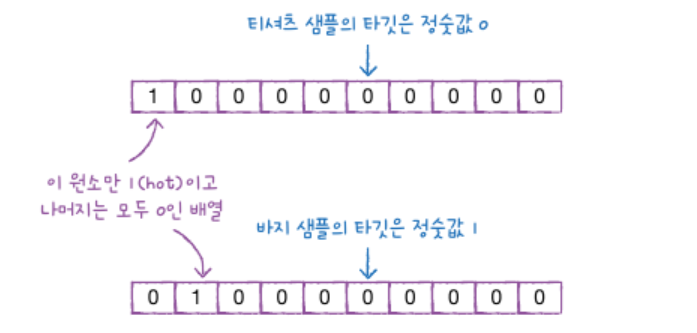

하지만 텐서플로에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 그냥 사용할 수 있다. 즉, **정수로된 타깃값으로 크로스 엔트로피 손실을 계산할 수 있다.**

그다음 comile()메서드의 metrics에 대해서 알아보자. 

케라스는 모델이 훈련할 때 에포크마다 손실 값을 출력해준다. 손실이 줄어드는 것을 보면 훈련이 잘 되었다는 것을 알 수 있을 것이다. 하지만 정확도를 함께 출력하면 더 좋을 것이다. 이를 위해 정확도 지표를 의미하는 accuracy를 지정했다.

#### 모델 훈련하기

In [21]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6048 - accuracy: 0.7945
Epoch 2/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4784 - accuracy: 0.8391
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4564 - accuracy: 0.8468
Epoch 4/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4431 - accuracy: 0.8522
Epoch 5/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4361 - accuracy: 0.8565


친정하게 에포크마다 걸린 시간과 손실(loss), 정확도(accuracy)를 출력해준다.

In [23]:
# 검증 세트로 모델 성능 확인하기
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4469 - accuracy: 0.8512


[0.4468747079372406, 0.8512499928474426]